In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from random import shuffle

%matplotlib notebook

In [2]:
im = imread('img/histimseg/pup_on_beach.jpg')
#im = imread('img/histimseg/beach.jpg')
#im = imread('img/histimseg/dog_in_grass.jpg')
#im = imread('img/histimseg/dog_on_grass.jpg')
#im = imread('img/histimseg/landscape.jpg')

# testing
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.imshow(im)
# ax = fig.add_subplot(434)
# ax.imshow(im[:,:,0],cmap='Reds_r')
# ax = fig.add_subplot(435)
# ax.imshow(im[:,:,1],cmap='Greens_r')
# ax = fig.add_subplot(436)
# ax.imshow(im[:,:,2],cmap='Blues_r')


In [3]:
'''Calculates Probability of a pixel belonging to that mask, based on the rgb histogram
    Logic: If the foreground has a big bin, and the pixel is in it, the pixel is more likely to be in the foreground
            ie, return the comparative size of the pixel's bin
    Note - slow for many iterations, so replaced with smaller code chunks, but left here for reference
'''
def hist_probability(image, mask, bins, x, y):
    r,g,b = image[y,x]
    
    r_hist, bin_edges = np.histogram(image[...,0], weights=mask, bins=bins)
    r_prob = r_hist[np.argwhere(bin_edges >= r)[0]-1]/sum(r_hist)
    
    g_hist, bin_edges = np.histogram(image[...,1], weights=mask, bins=bins)
    g_prob = g_hist[np.argwhere(bin_edges >= g)[0]-1]/sum(g_hist)
    
    b_hist, bin_edges = np.histogram(image[...,2], weights=mask, bins=bins)
    b_prob = b_hist[np.argwhere(bin_edges >= b)[0]-1]/sum(b_hist)
     
    return (r_prob + g_prob + b_prob)[0]/3


'''Calculates the 3d histogram for a given image/mask'''
def calc_histogram(image, mask, bins):
    hist_range = (image.min(),image.max())
    r_hist, bin_edges = np.histogram(image[...,0], bins, hist_range, weights=mask)
    g_hist, _________ = np.histogram(image[...,1], bins, hist_range, weights=mask)
    b_hist, _________ = np.histogram(image[...,2], bins, hist_range, weights=mask)
    return [r_hist, g_hist, b_hist], bin_edges


'''Calculates the probability of a pixel belonging to a histogram by summing comparative areas of histBins '''
def calc_probability(pixel, histogram, bin_edges):
    prob = 1
    for col, hist in zip(pixel, histogram):
        prob += hist[np.argwhere(bin_edges >= col)[0]-1]/sum(hist)
    return prob/pixel.shape[0]

'''Adds or removes a pixel from a histogram bin'''
def update_histogram(histogram, pixel, bin_edges, add):
    for col, hist in zip(pixel, histogram):
        bin = np.argwhere(bin_edges >= col)[0]-1
        if add:
            hist[bin] += 1
        else:
            hist[bin] -= 1 if hist[bin]>0 else 0
    return histogram


# test
# mask=np.zeros_like(im[...,0])
# mask[im[...,0]<120]=1
# hist_probability(im,mask, 20,30,30)

# mask=np.zeros_like(im[...,0])
# mask[im[...,0]<120]=1
# test = histogram(im,mask, 10)

In [4]:
''' Calculates the average colour in the mask, for pretty outputs'''
def calc_avg_col(image, mask):
    r = np.mean(image[mask==1][:,0])
    g = np.mean(image[mask==1][:,1])
    b = np.mean(image[mask==1][:,2])
    return (r,g,b)
    

In [5]:
'''Main Iterative loop code'''
def histogram_segment(image, max_iters=20, bins=7, previous=None, random=False):
    h,w,_ = image.shape 

    if previous is None:
        fore_mask = np.zeros_like(image[:,:,0])
        back_mask = np.zeros_like(image[:,:,0])
        intensity = image[:,:,0]+image[:,:,1]+image[:,:,2]
        fore_mask[intensity < 150] = 1
        back_mask[intensity >=100] = 1
#         fore_mask[w//2-20:w//2+20,w//2-20:w//2+20] = 1
#         back_mask[w//2-20:w//2,w//2-20:w//2] = 1
#         back_mask[range(h-15,h), :] = 1
#         back_mask[range(0,15), :] = 1
#         back_mask[:, range(h-15,h)] = 1
#         back_mask[:, range(0,15)] = 1

        fore_hist, bin_edges = calc_histogram(image, fore_mask, bins)
        back_hist, bin_edges = calc_histogram(image, back_mask, bins)
    else:
        fore_mask, back_mask, fore_hist, back_hist, bin_edges = previous  
        
    coordinates = [(x,y) for x in range(w) for y in range(h)]
    for i in range(max_iters):
        print(".")
        if random:
            shuffle(coordinates)
        for x,y in coordinates:
            p_fore = calc_probability(image[y,x], fore_hist, bin_edges)
            p_back = calc_probability(image[y,x], back_hist, bin_edges)
            if p_fore > p_back:
                fore_hist = update_histogram(fore_hist, image[y,x], bin_edges, True)
                if back_mask[y,x]:
                    back_hist = update_histogram(back_hist, image[y,x], bin_edges, False)
                fore_mask[y,x] = 1
                back_mask[y,x] = 0
                
            else:
                back_hist = update_histogram(back_hist, image[y,x], bin_edges, True)
                if fore_mask[y,x]:
                    fore_hist = update_histogram(fore_hist, image[y,x], bin_edges, False)
                fore_mask[y,x] = 0
                back_mask[y,x] = 1
    out_image = np.zeros_like(image)
    out_image[fore_mask==1] = calc_avg_col(image, fore_mask)
    out_image[back_mask==1] = calc_avg_col(image, back_mask)
    return out_image, [fore_mask, back_mask, fore_hist, back_hist, bin_edges]
    
    
# out = segment(im,1)
# fig = plt.figure()
# ax2 = fig.add_subplot(142)
# ax2.imshow(out)
   

In [6]:
'''Export images every iteration, using prev to pass previous histograms back in'''
bins=7
im_out0, prev = histogram_segment(im, 0, bins)
im_out1, prev = histogram_segment(im, 1, bins, prev)
im_out2, prev = histogram_segment(im, 1, bins, prev)
im_out3, prev = histogram_segment(im, 1, bins, prev)
im_out4, prev = histogram_segment(im, 1, bins, prev)
im_out5, prev = histogram_segment(im, 1, bins, prev)
im_out10, prev = histogram_segment(im, 5, bins, prev)
#im_out15, prev = histogram_segment(im, 5, bins, prev)

.
.
.
.
.
.
.
.
.
.


<IPython.core.display.Javascript object>


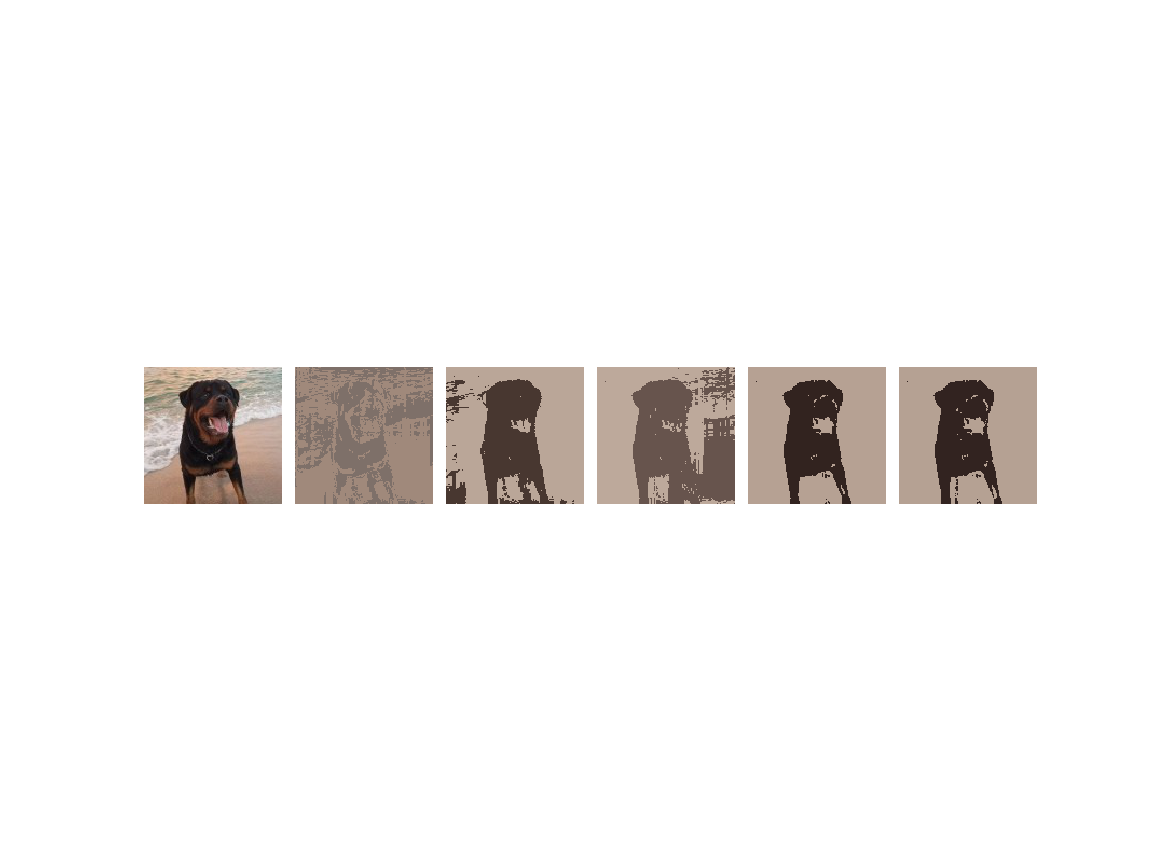

In [7]:
fig = plt.figure()
ax = fig.add_subplot(161)
ax.imshow(im)
plt.axis('off')

ax = fig.add_subplot(162)
ax.imshow(im_out1)
plt.axis('off')

ax = fig.add_subplot(163)
ax.imshow(im_out2)
plt.axis('off')

ax = fig.add_subplot(164)
ax.imshow(im_out3)
plt.axis('off')

# ax = fig.add_subplot(175)
# ax.imshow(im_out4)
# plt.axis('off')

ax = fig.add_subplot(165)
ax.imshow(im_out5)
plt.axis('off')

ax = fig.add_subplot(166)
ax.imshow(im_out10)
plt.axis('off')

# ax = fig.add_subplot(177)
# ax.imshow(im_out15)
# plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig("pup_on_beach_5.png", bbox_inches='tight', pad_inches = 0)